In [25]:
import e2cnn
from e2cnn import gspaces
from e2cnn import nn as e2nn
import torch
import torch.multiprocessing
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from src.nn_training import Group
from tqdm.notebook import tqdm
import seaborn as sns
import gzip
import torch.utils.data as data_utils
import pickle

from s2cnn_soft.s2_conv import S2Convolution
from s2cnn_soft.so3_conv import SO3Convolution, SO3_fft_real
from s2cnn_soft.s2_grid import s2_near_identity_grid
from s2cnn_soft.so3_grid import so3_near_identity_grid
from s2cnn_soft.so3_integrate import so3_integrate

from s2cnn_soft.so3_fft import _setup_wigner
from lie_learn.representations.SO3.wigner_d import wigner_d_matrix

from matplotlib import rc
rc("text", usetex=False)
sns.set_style()

In [2]:
def load_data(path, batch_size):

    with gzip.open(path, 'rb') as f:
        dataset = pickle.load(f)

    train_data = torch.from_numpy(
        dataset["train"]["images"][:, None, :, :].astype(np.float32))
    train_labels = torch.from_numpy(
        dataset["train"]["labels"].astype(np.int64))

    # TODO normalize dataset
    # mean = train_data.mean()
    # stdv = train_data.std()

    train_dataset = data_utils.TensorDataset(train_data, train_labels)
    train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_data = torch.from_numpy(
        dataset["test"]["images"][:, None, :, :].astype(np.float32))
    test_labels = torch.from_numpy(
        dataset["test"]["labels"].astype(np.int64))

    test_dataset = data_utils.TensorDataset(test_data, test_labels)
    test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, train_dataset, 

In [3]:
def get_schatten_norm_sum(fcoeffs, irrep_sizes, l):
    """
    Given the Fourier coefficients of the linearization of our network,
    this f-n computes the expression for which we want to reach a scaling
    of its stationary point in our main theorems (Thm 4.2 and Thm 4.4).
    """
    
    # all we're doing here is getting the 2/l norm of the singular values
    # of the block diagonal matrix that has each of the irreps of dim n
    # repeated n times along its diagonal
    
    # our code could also be written more cleanly/concisely as
    # block_diag_matrix_irrs = torch.block_diag(*[torch.block_diag(*([flat_irrep.reshape(size, size)] * size)) 
    #                                                              for size, flat_irrep in zip(irrep_sizes, fcoeffs)])
    # sigmas = torch.linalg.svdvals(block_diag_matrix_irrs)
    # return torch.linalg.vector_norm(sigmas, ord=(2./3.))
    # but that'd be a bit slower because of the SVD on a larger (though sparse) matrix
    
    sum_of_schatten_norms = 0.
    flat_irreps_list = torch.split(fcoeffs, [s ** 2 for s in irrep_sizes])

    for flat_irrep, irrep_size in zip(flat_irreps_list, irrep_sizes):
        irrep = flat_irrep.reshape(irrep_size, irrep_size)
        try:
            sigmas = torch.linalg.svdvals(irrep)
        except:
            return None
        sum_of_schatten_norms += irrep_size * torch.linalg.vector_norm(sigmas, ord=(2. / l)) ** (2. / l)
    return sum_of_schatten_norms ** (l / 2.)


def eval_schatten_norm(net, inps):
    net.eval()
    sch_norms = []
    interm, out = net(inps)
    out.sum().backward()
    linearization_all = interm.grad
    sch_norm_all = []
    
    for i in range(linearization_all.size(1)):
        linearization = linearization_all[:, 0:1, ...]
        batch_size = linearization.size(0)    
        linearization /= torch.linalg.norm(linearization.reshape(batch_size, -1),
                                           dim=1).reshape(batch_size, 1, 1, 1, 1)

        fspace_linearization = SO3_fft_real.apply(linearization,
                                                  s2net.conv1.b_out).squeeze(2).permute([2, 1, 0])
        fcoeffs_real = fspace_linearization[0]
        fcoeffs_imag = fspace_linearization[1]
        fcoeffs = torch.complex(fcoeffs_real, fcoeffs_imag)
        irrep_sizes = [(2 * i + 1) for i in range(net.b_l1)]
        for sample in fcoeffs:
            sch_norm = get_schatten_norm_sum(sample, irrep_sizes, 3)
            sch_norms.append(sch_norm)
        sch_norm_for_lin = torch.stack(sch_norms).mean()
        sch_norm_all.append(sch_norm_for_lin)
    net.train()
    return torch.stack(sch_norm_all).mean()


def exp_loss(y_pred, y):
    """
    Exponential loss for classification.
    """
    return torch.mean(torch.exp(-y_pred * y))

def postprocess(batch):
    x, y = batch
    # classify 0 vs 5, ignore other digits
    x = x[(y == 0) + (y == 5)]
    y = y[(y == 0) + (y == 5)]
    y[y == 0] = 1
    y[y == 5] = 0
    y = y.reshape(-1)
    reduced_bs = len(y)
    return x, y

In [4]:
train_loader, _, train_dataset = load_data('s2_mnist.gz', 64)

In [5]:
for ims, labels in train_loader:
    x, y = ims, labels
    break

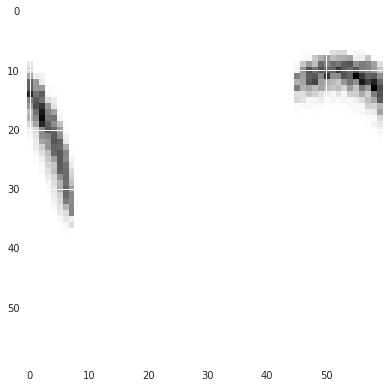

In [6]:
plt.imshow(x[0].permute(1,2,0).numpy())

In [7]:
class S2ConvNet_original(nn.Module):

    def __init__(self):
        super(S2ConvNet_original, self).__init__()

        f1 = 5
        f2 = 100
        f_output = 2

        b_in = 30
        self.b_l1 = 5
        b_l2 = 3

        grid_s2 = s2_near_identity_grid()
        grid_so3 = so3_near_identity_grid()

        self.conv1 = S2Convolution(
            nfeature_in=1,
            nfeature_out=f1,
            b_in=b_in,
            b_out=self.b_l1,
            grid=grid_s2)

        self.conv2 = SO3Convolution(
            nfeature_in=f1,
            nfeature_out=f2,
            b_in=self.b_l1,
            b_out=b_l2,
            grid=grid_so3)

        self.conv3 = SO3Convolution(
            nfeature_in=f2,
            nfeature_out=f2,
            b_in=b_l2,
            b_out=b_l2,
            grid=grid_so3)

        self.out_layer = nn.Linear(f2, f_output)
        
        self.is_spherical = True
        self.is_fc = False

    def forward(self, x):

        x = self.conv1(x)
        interm = F.relu(x)
        interm.retain_grad()
        
        x = self.conv2(interm)
        x = F.relu(x)
        x = self.conv3(x)

        x = so3_integrate(x)
        x = self.out_layer(x.reshape(x.size(0), -1))

        return interm, x

In [8]:
s2net = S2ConvNet_original()
interm, out = s2net(x)
out.sum().backward()

In [9]:
linearization = interm.grad[:, 0:1, ...]
batch_size = linearization.size(0)
linearization /= torch.linalg.norm(linearization.reshape(batch_size, -1), dim=1).reshape(batch_size, 1, 1, 1, 1)
fspace_linearization = SO3_fft_real.apply(linearization, s2net.conv1.b_out).squeeze(2).permute([2, 1, 0])
fcoeffs_real = fspace_linearization[0]
fcoeffs_imag = fspace_linearization[1]
fcoeffs = torch.complex(fcoeffs_real, fcoeffs_imag)
fcoeffs.shape

torch.Size([64, 165])

In [10]:
irrep_sizes = [(2 * i + 1) for i in range(s2net.b_l1)]
get_schatten_norm_sum(fcoeffs[0], irrep_sizes, l=2)

tensor(0.1097)

#### Verify unitarity of Wigner-D matrices

In [11]:
l = 10
beta = 0
w = wigner_d_matrix(l, beta)
np.max(np.abs(w.T @ w - np.identity(2 * l + 1)))

2.220446049250313e-16

In [12]:
class FCnet(torch.nn.Module):
    def __init__(self):
        super(FCnet, self).__init__()
        self.lin1 = nn.Linear(5000, 1024)
        self.lin2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()

        self.nonlinear = True
        self.is_g = False
        self.is_fc = True
        self.l = 3

        b_in = 30
        self.b_l1 = 5
        grid_s2 = s2_near_identity_grid()
        self.s2conv = S2Convolution(
            nfeature_in=1,
            nfeature_out=5,
            b_in=b_in,
            b_out=self.b_l1,
            grid=grid_s2)

        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.s2conv(x)
        interm = self.relu(x)
        interm.retain_grad()
        x = self.lin1(interm.reshape(batch_size, -1))
        x = self.relu(x)
        x = self.lin2(x)
        
        return interm, x

In [13]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=50,
                               kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=10,
                               kernel_size=3, stride=2)
        self.lin = nn.Linear(230, 2)
        self.relu = nn.ReLU()

        self.nonlinear = True
        self.is_g = False
        self.is_fc = False
        self.l = 3

        b_in = 30
        self.b_l1 = 5
        grid_s2 = s2_near_identity_grid()
        self.s2conv = S2Convolution(
            nfeature_in=1,
            nfeature_out=5,
            b_in=b_in,
            b_out=self.b_l1,
            grid=grid_s2)

        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.s2conv(x)
        interm = self.relu(x)
        interm.retain_grad()
        x = self.conv1(interm.reshape(batch_size, 5, 100, 10))
        # x = self.conv1(interm.reshape(batch_size, -1))
        x = self.relu(x)
        x = self.conv2(x)
        x = self.lin(x.reshape(batch_size, -1))
        return interm, x

# Training

In [15]:
dataset = [postprocess(batch) for batch in train_loader]

## Spherical CNN

In [16]:
epochs = 400
num_batches = 3
init_lr= 5e-4
N = 1
# criterion = exp_loss
criterion = torch.nn.CrossEntropyLoss()

In [18]:
%%time
results_scnn = []
for run_itr in range(N):
    net = S2ConvNet_original()
    net.train()

    # freeze lifting layer
    optimizer = optim.SGD(net.parameters(), lr=init_lr)

    loss = torch.Tensor([1.])
    acc = torch.Tensor([0.])

    for epoch in range(epochs):
        # itr = tqdm(enumerate(dataset[0:num_batches]))
        itr = enumerate(dataset[0:num_batches])
        if loss.isnan().item():
            print('Fail')
            break

        if epoch == 100:
            for g in optimizer.param_groups:
                g['lr'] *= 1.5

        for i, batch in itr:
            x, y = batch
            if epoch % 20 == 0 and i == 0:
                # print(f'(mean of) first layer weights {net.conv1.kernel.mean():.5f}')
                # print(f'second layer weights {net.conv2.kernel.mean():.5f}')
                # print(f'third layer weights {net.conv3.kernel.mean():.5f}')
                # print(f'fourth layer weights {net.conv4.kernel.mean():.5f}')
                sch_norm = eval_schatten_norm(net, x)
                print(f'Schatten norm at epoch {epoch} is {sch_norm:.3f}; acc: {acc.item():.4f}')
                results_scnn.append([run_itr, epoch, sch_norm.item(), loss.item()])

            optimizer.zero_grad()
            interm, preds = net(x)
            loss = criterion(preds, y)
            loss.backward()
            net.conv1.kernel.grad = torch.zeros_like(net.conv1.kernel.grad)
            net.conv1.bias.grad = torch.zeros_like(net.conv1.bias.grad)
            optimizer.step()

#             acc = torch.sum(torch.sign(preds) == y) / len(y)
            acc = torch.sum((preds[:, 0] < preds[:, 1]) == y) / len(y)

            # itr.set_description(f'loss: {loss.item():.4f}, acc: {acc.item():.3f}')

Schatten norm at epoch 0 is 0.413; acc: 0.0000
Schatten norm at epoch 20 is 0.413; acc: 0.4667
Schatten norm at epoch 40 is 0.413; acc: 0.5333
Schatten norm at epoch 60 is 0.413; acc: 0.5333
Schatten norm at epoch 80 is 0.413; acc: 0.6000
Schatten norm at epoch 100 is 0.413; acc: 0.6000
Schatten norm at epoch 120 is 0.413; acc: 0.5333
Schatten norm at epoch 140 is 0.413; acc: 0.6000
Schatten norm at epoch 160 is 0.413; acc: 0.6000
Schatten norm at epoch 180 is 0.413; acc: 0.5333
Schatten norm at epoch 200 is 0.412; acc: 0.8000
Schatten norm at epoch 220 is 0.412; acc: 0.8000
Schatten norm at epoch 240 is 0.412; acc: 0.8000
Schatten norm at epoch 260 is 0.412; acc: 0.8000
Schatten norm at epoch 280 is 0.412; acc: 0.6667
Schatten norm at epoch 300 is 0.411; acc: 0.8667
Schatten norm at epoch 320 is 0.411; acc: 0.9333
Schatten norm at epoch 340 is 0.411; acc: 0.9333
Schatten norm at epoch 360 is 0.411; acc: 0.9333
Schatten norm at epoch 380 is 0.411; acc: 0.9333
CPU times: user 17min 12s,

In [19]:
dfs_scnn = pd.DataFrame(results_scnn, columns=['N', 'epoch', 'schatten norm', 'loss'])

In [20]:
dfs_scnn.to_csv('spehrical_cnn_mnist.csv', index=False)

In [17]:
dfs_scnn = pd.read_csv('spehrical_cnn_mnist.csv')

# FC net

In [20]:
epochs = 400
num_batches = 3
init_lr= 5e-4
N = 1

In [21]:
%%time
results_fcnet = []
for run_itr in tqdm(range(N)):
    net = FCnet()
    optimizer = optim.SGD(net.parameters(), lr=init_lr)
    loss = torch.Tensor([1.])
    acc = torch.Tensor([0.])    
    for epoch in tqdm(range(epochs)):
        if loss.isnan().item():
            break
        # itr = tqdm(enumerate(dataset[0:num_batches]))
        itr = enumerate(dataset[0:num_batches])
        if epoch == 150:
            for g in optimizer.param_groups:
                g['lr'] /= 5.
        for i, batch in itr:
            x, y = batch
            if epoch % 5 == 0 and i == 0:
                sch_norm = eval_schatten_norm(net, x)
#                 print(f'Schatten norm at epoch {epoch} is {sch_norm:.1f}; acc is {acc.item()}')
                results_fcnet.append([run_itr, epoch, sch_norm.item(), loss.item()])

            optimizer.zero_grad()
            interm, preds = net(x)
            loss = criterion(preds, y)
            loss.backward()
            net.s2conv.kernel.grad = torch.zeros_like(net.s2conv.kernel.grad)
            net.s2conv.bias.grad = torch.zeros_like(net.s2conv.bias.grad)
            optimizer.step()
            acc = torch.sum((preds[:, 0] < preds[:, 1]) == y) / len(y)
#             acc = torch.sum(torch.sign(preds - 1.) == y) / len(y)
            # itr.set_description(f'loss: {loss.item():.4f}, acc: {acc.item():.3f}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 5min 46s, sys: 10min 51s, total: 16min 37s
Wall time: 1min 48s


In [22]:
dfs_fcnet = pd.DataFrame(results_fcnet, columns=['N', 'epoch', 'schatten norm', 'loss'])

In [23]:
dfs_fcnet.to_csv('fcnet_spherical_mnist.csv', index=False)

In [18]:
dfs_fcnet = pd.read_csv('fcnet_spherical_mnist.csv')

## CNN

In [18]:
epochs = 400
num_batches = 3
init_lr= 5e-4
N = 1

In [40]:
%%time
results_cnn = []
for run_itr in range(N):
    net = CNN()
    optimizer = optim.SGD(net.parameters(), lr=init_lr)
    loss = torch.Tensor([1.])
    acc = torch.Tensor([0.])    
    for epoch in range(epochs):
        if loss.isnan().item():
            print('Fail')
            break
#         itr = tqdm(enumerate(dataset[0:num_batches]))
        itr = enumerate(dataset[0:num_batches])
        if epoch == 100:
            for g in optimizer.param_groups:
                g['lr'] *= 1.5
        for i, batch in itr:
            x, y = batch
            if epoch % 20 == 0 and i == 0:
                sch_norm = eval_schatten_norm(net, x)
                print(f'Schatten norm at epoch {epoch} is {sch_norm:.3f}; acc is {acc.item()}')
                results_cnn.append([run_itr, epoch, sch_norm.item(), loss.item()])

            optimizer.zero_grad()
            interm, preds = net(x)
            loss = criterion(preds, y)
            loss.backward()
            net.s2conv.kernel.grad = torch.zeros_like(net.s2conv.kernel.grad)
            net.s2conv.bias.grad = torch.zeros_like(net.s2conv.bias.grad)
            optimizer.step()
            acc = torch.sum((preds[:, 0] < preds[:, 1]) == y) / len(y)
#             acc = torch.sum(torch.sign(preds - 1.) == y) / len(y)
#             itr.set_description(f'loss: {loss.item():.4f}, acc: {acc.item():.3f}')

Schatten norm at epoch 0 is 1.884; acc is 0.0
Schatten norm at epoch 20 is 1.890; acc is 1.0
Schatten norm at epoch 40 is 1.891; acc is 1.0
Schatten norm at epoch 60 is 1.892; acc is 1.0
Schatten norm at epoch 80 is 1.893; acc is 1.0
Schatten norm at epoch 100 is 1.894; acc is 1.0
Schatten norm at epoch 120 is 1.895; acc is 1.0
Schatten norm at epoch 140 is 1.894; acc is 1.0
Schatten norm at epoch 160 is 1.895; acc is 1.0
Schatten norm at epoch 180 is 1.896; acc is 1.0
Schatten norm at epoch 200 is 1.896; acc is 1.0
Schatten norm at epoch 220 is 1.898; acc is 1.0
Schatten norm at epoch 240 is 1.899; acc is 1.0
Schatten norm at epoch 260 is 1.899; acc is 1.0
Schatten norm at epoch 280 is 1.899; acc is 1.0
Schatten norm at epoch 300 is 1.897; acc is 1.0
Schatten norm at epoch 320 is 1.897; acc is 1.0
Schatten norm at epoch 340 is 1.898; acc is 1.0
Schatten norm at epoch 360 is 1.900; acc is 1.0
Schatten norm at epoch 380 is 1.899; acc is 1.0
CPU times: user 4min 35s, sys: 9min 37s, total

In [41]:
dfs_cnn = pd.DataFrame(results_cnn, columns=['N', 'epoch', 'schatten norm', 'loss'])

In [42]:
dfs_cnn.to_csv('cnn_e2.csv', index=False)

In [19]:
dfs_cnn = pd.read_csv('cnn_e2.csv') #('data/spherical_results/cnn_e2.csv')

# Plots

In [20]:
scaling=1.8
color_palette = sns.color_palette('colorblind', 3)

/tmp/ipykernel_84145/1004953689.py:2: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


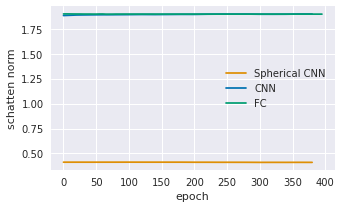

In [29]:
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

plt.figure(figsize=(scaling * 2.695, scaling * 1.666))
sns.lineplot(data=dfs_scnn, x="epoch", y="schatten norm", label='Spherical CNN',
             color=color_palette[1])
sns.lineplot(data=dfs_cnn, x="epoch", y="schatten norm", label='CNN',
             color=color_palette[0])
sns.lineplot(data=dfs_fcnet, x="epoch", y="schatten norm", label='FC',
             color=color_palette[2])
# plt.ylabel(r"$\displaystyle\|\widehat{\boldsymbol{\beta}}\|^{(S)}_{2/L}$")
plt.legend()
plt.savefig('spherical_cnn_fourier_norm.pdf')
plt.show()

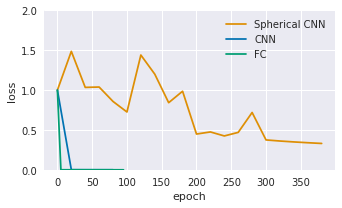

In [28]:
plt.figure(figsize=(scaling * 2.695, scaling * 1.666))
sns.lineplot(data=dfs_scnn, x="epoch", y="loss", label='Spherical CNN',
             color=color_palette[1])
sns.lineplot(data=dfs_cnn[dfs_cnn['epoch'] < 100], x="epoch", y="loss", label='CNN',
             color=color_palette[0])
sns.lineplot(data=dfs_fcnet[dfs_fcnet['epoch'] < 100], x="epoch", y="loss", label='FC',
             color=color_palette[2])
plt.ylim(0, 2)
plt.legend();
plt.savefig('spherical_cnn_loss.pdf')
plt.show()